# Alireza Taban, 40105424

###               This homework has been done on my PC

### 1. Importing libraries
* pandas: Reading csv file
* tensorflow: Creating and training our model
* sklearn: Data separation
* numpy: Working with arrays and some functions like random, save, load, ...
* glob: Finding images from directory
* cv2: Reading and preprocessing images
* matplotlib: Plotting the loss plot and showing images

In [1]:
# importing needed libraries
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

### 2. Reading and Preprocessing Data
* First Reading labels using pandas
    * Plotting the distribution of labels
    * Detecting zero labels using a mask and randomly removing (prob=0.01) zero labels
    
    
* Second Finding and Reading images using glob and cv2 and preprocessing
    * Within a for loop over all images, preprocessing the images and storing their labels 
    * Plotting the distribution of final labels

In [2]:
# reading backward data using pandas dataframe
b_dataframe = pd.read_csv("data\\b_data\\driving_log.csv", header=None)
b_labels = b_dataframe[3]
print(b_labels.shape)

# reading forward data using pandas dataframe
f_dataframe = pd.read_csv("data\\f_data\\driving_log.csv", header=None)
f_labels = f_dataframe[3]
print(f_labels.shape)

# According to our collected data, first we have center camera, second camera and right camera
# So we can concatenate our labels 3 times for each backward and forward data separately
b_labels = np.tile(b_labels, 3)
f_labels = np.tile(f_labels, 3)
labels = np.hstack([b_labels, f_labels])

print('---------------------------------')
print("Number of whole data: ", labels.shape[0])

(6403,)
(5725,)
---------------------------------
Number of whole data:  36384


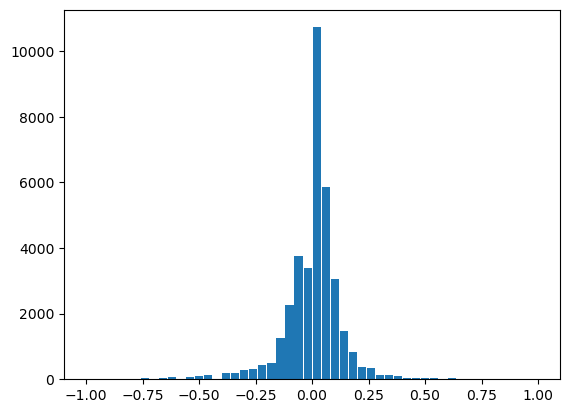

In [3]:
# Plotting the distribution of our continuous labels
# As you can see most of the labels are equal to 0, but the distribution is similar to Normal Distribution
plt.hist(labels, 50, rwidth=0.9)
plt.show()

In [4]:
# Creating a mask for detecting zero labels and randomly removing them (prob=0.01)
non_zero_condition = (labels != 0)
random_condition = (np.random.random_sample(labels.shape) < 0.01)
selected = np.logical_or(non_zero_condition, random_condition)

In [5]:
labels_new = list()
data_list = list()
num = len(glob.glob('data\\*\\*\\*.jpg'))

In [6]:
# Preprocessing
for index, Address in enumerate(glob.glob("data\\*\\*\\*.jpg")):
    if selected[index]:
        # Reading image
        image = cv2.imread(Address)
        # Croping image
        image = image[60:135, :, :]
        # Changing image space from RGB to YUV
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        # Noising!
        image = cv2.GaussianBlur(image, (3, 3), 0)
        # Resizing according to Nvidia
        image = cv2.resize(image, (200, 66))
        # Normalizing
        image = (image/127.5) - 1.0
        
        # Storing preprocessed image
        data_list.append(image)
        
        # Recommended: For left/right cameras adding/subtracting 0.2 to streering angle
        l_r = Address.split("\\")[-1].split("_")[0]
        if l_r == "left":
            labels[index] += 0.2
        elif l_r == "right":
            labels[index] -= 0.2
            
        # Storing updated label for each chosen image from selected list
        labels_new.append(labels[index])
       
    if index % 6000 == 0:
        print(f"--> {index}/{num}")
        
print("List of preprocessed selected images (data_list) and their labels (labels_new) is ready!")

--> 0/36384
--> 6000/36384
--> 12000/36384
--> 18000/36384
--> 24000/36384
--> 30000/36384
--> 36000/36384
List of preprocessed selected images (data_list) and their labels (labels_new) is ready!


In [7]:
len(data_list), len(labels_new) # Dimension Check!

(29685, 29685)

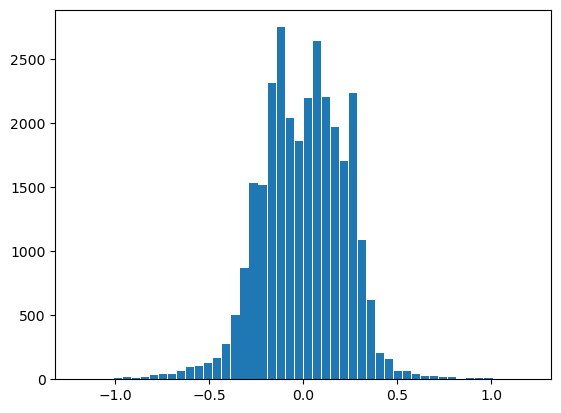

In [8]:
# Plotting the distribution of our final continuous labels (similar to Normal Distribution)
plt.hist(labels_new, 50, rwidth=0.9)
plt.show()

In [9]:
del labels
del selected
np.save('preprocessed_data.npy', data_list)
np.save('preprocess_data_labels.npy', labels_new)

* Restart Kernel and then continue

In [2]:
# Loading data after restarting kernel
data_list = np.load('preprocessed_data.npy')
labels = np.load('preprocess_data_labels.npy')

In [3]:
len(data_list), len(labels) # Dimension Check!

(29685, 29685)

In [4]:
# Spliting data
data = np.array(data_list)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [5]:
del data
del data_list
np.save('x_train.npy', x_train)
np.save('x_test.npy', x_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

* Restart Kernel and then continue

### 3. Data Augmentation
* Flip ↔️
* Rotation 🌀🔄
* Zoom 🔍
* Pan 🌐
* Brightness ✨

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
x_train.shape

(23797, 66, 200, 3)

In [4]:
# Augmenting the input training data
def augmentation(x, y):
#     new_y = []
#     new_x = []
    for j in range(len(x)):
        if (np.random.random() < 0.6):
            
            # Flip
            if (np.random.random() < 0.65):
                x[j] = cv2.flip(x[j], 1)
                y[j] = -y[j]
#                 new_y.append(y[j])
#                 new_x.append(x[j])
            # Rotation
            if (np.random.random_sample() < 0.65):
                rotate = layers.RandomRotation(factor=(-10 / 360, 10 / 360), fill_mode="constant")
                img_rotated = rotate(tf.expand_dims(x[j], 0)) 
                img_rotated = tf.squeeze(img_rotated, 0) 
                x[j] = img_rotated.numpy()
#                 new_y.append(y[j])
#                 new_x.append(x[j])
            # Zoom
            if (np.random.random() < 0.65):
                zoom = layers.RandomZoom(height_factor=(-0.15, -0.05), fill_mode="constant")
                img_zoomed = zoom(tf.expand_dims(x[j], 0)) 
                img_zoomed = tf.squeeze(img_zoomed, 0) 
                x[j] = img_zoomed.numpy()
#                 new_y.append(y[j])
#                 new_x.append(x[j])

            # Pan
            if (np.random.random() < 0.65):
                TM = np.float32([[1, 0, x[j].shape[1] * np.random.uniform(-0.1, 0.1)], [0, 1, x[j].shape[0] * np.random.uniform(-0.1, 0.1)]])
                x[j] = cv2.warpAffine(x[j], TM, (x[j].shape[1], x[j].shape[0]))
#                 new_y.append(y[j])
#                 new_x.append(x[j])
            
            # Brightness
            if (np.random.random_sample() < 0.65):
                brightness = layers.RandomBrightness(0.3, value_range=(-1.0, 1.0))
                img_brightened = brightness(tf.expand_dims(x[j], 0))  
                img_brightened = tf.squeeze(img_brightened, 0) 
                x[j] = img_brightened.numpy()
#                 new_y.append(y[j])
#                 new_x.append(x[j])
#     new_y1 = np.array(new_y)
#     new_x1 = np.array(new_x)
#     return new_x1, new_y1

In [5]:
# If enough RAM is available this block can be used instead of the next block
# x_temp, y_temp = augmentation(x_train, y_train)
# x_train_new = np.concatenate([x_train, x_temp])
# del x_train
# del x_temp
# y_train_new = np.concatenate([y_train, y_temp])
# del y_train
# del y_temp

In [6]:
# Running the augmentation function and replacing the augmented images with their original images
augmentation(x_train, y_train)

### 4. Mini-Batch Generator and Training the Model
* 2 approaches for generating every mini-batch is considered
    * my_generator1: Generates every mini-batch while training the model, with the assumption that the data is augmented earlier
    * my_generator2: After generating every mini-batch, run augmentation function and concatenates new data to the mini-batch generated
* Creating model using tensorflow Sequential function according to the architecture given 🛠️
    * Compiling the model to set adam optimizer and MSE as loss function and MAE as a metric
* Plotting the loss-epoch and val_loss-epoch curves (to check training procedure and overfitting) 📈

In [7]:
# Yielding a mini-batch of data, every time the function is called
def my_generator1(x, y, batch_size):
    # Using while True for restarting for next epoch
    while True:
        # Iterating on every mini-batches of whole data
        for i in range(0, len(x), batch_size):
            
            x_batch = x[i : i+batch_size]
            y_batch = y[i : i+batch_size]

            yield x_batch, y_batch

In [7]:
# def my_generator2(x, y, batch_size):
#     while True:
#         for i in range(0, len(x), batch_size):
#             x_batch = x[i : i+batch_size]
#             y_batch = y[i : i+batch_size]

#             x_batch_aug, y_batch_aug = augmentation(x_batch, y_batch)

#             yield (
#                 np.concatenate([x_batch, x_batch_aug]),
#                 np.concatenate([y_batch, y_batch_aug])
#             )

In [8]:
# Defining the model according to the given architecture
model = models.Sequential([
#         layers.Conv2D(24, (5, 5), activation="relu", input_shape=(66, 200, 3)),
        layers.Conv2D(24, (5, 5), activation="relu", input_shape=(66, 200, 3), strides=(2, 2)),
        layers.Conv2D(36, (5, 5), activation="relu", strides=(2, 2)),
        layers.Conv2D(48, (5, 5), activation="relu", strides=(2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(10, activation="relu"),
        layers.Dense(1, activation="linear"),
])

# Setting the Adam optimizer and MSE for loss and MAE for regression metrics
model.compile(optimizer="adam",
              loss="mse",
              metrics=["mae"])

# History of the model's information after training
hist = model.fit(my_generator1(x_train, y_train, batch_size=32),
                 steps_per_epoch=len(x_train)//32,
                 epochs=10,
                 validation_data=(x_test, y_test),
                )
# history = model.fit(my_generator(x_train_new, y_train_new, batch_size=32),
#                  steps_per_epoch=len(x_train)//32,
#                  epochs=10,
#                  validation_data=(x_test, y_test),
#                 )


Epoch 1/10


743/743 [==============================] - 65s 84ms/step - loss: 0.0293 - mae: 0.1304 - val_loss: 0.0220 - val_mae: 0.1095
Epoch 2/10
743/743 [==============================] - 59s 79ms/step - loss: 0.0216 - mae: 0.1099 - val_loss: 0.0193 - val_mae: 0.1006
Epoch 3/10
743/743 [==============================] - 57s 77ms/step - loss: 0.0196 - mae: 0.1040 - val_loss: 0.0181 - val_mae: 0.0975
Epoch 4/10
743/743 [==============================] - 55s 74ms/step - loss: 0.0183 - mae: 0.1002 - val_loss: 0.0167 - val_mae: 0.0928
Epoch 5/10
743/743 [==============================] - 57s 77ms/step - loss: 0.0176 - mae: 0.0980 - val_loss: 0.0170 - val_mae: 0.0936
Epoch 6/10
743/743 [==============================] - 56s 75ms/step - loss: 0.0167 - mae: 0.0957 - val_loss: 0.0169 - val_mae: 0.0942
Epoch 7/10
743/743 [==============================] - 56s 76ms/step - loss: 0.0159 - mae: 0.0934 - val_loss: 0.0170 - val_mae: 0.0938
Epoch 8/10
743/743 [==============================] - 56s 7

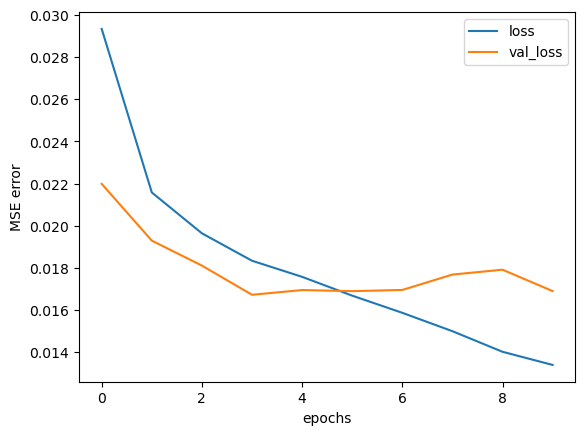

In [9]:
# Plotting the loss value during training
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("MSE error")
plt.legend()
plt.show()

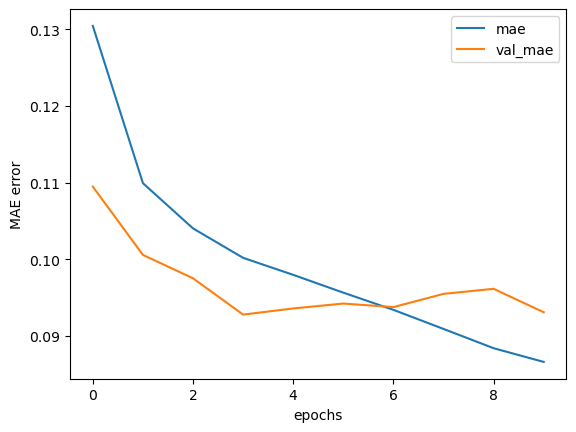

In [10]:
# Plotting the MAE value during training
plt.plot(hist.history["mae"], label="mae")
plt.plot(hist.history["val_mae"], label="val_mae")
plt.xlabel("epochs")
plt.ylabel("MAE error")
plt.legend()
plt.show()

In [12]:
model.save("my_self_driving_model.h5")

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1